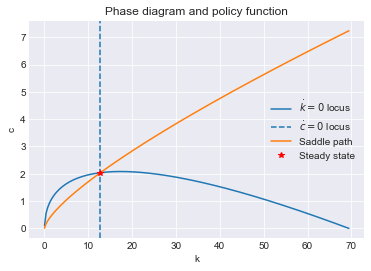

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy import interpolate

# Plot formatting
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')

class RCKmod:
    
    def __init__(self,rho,alpha,theta,xi,delta,phi):
        
        self.rho = rho
        self.alpha = alpha
        self.theta = theta
        self.xi = xi
        self.delta = delta
        self.phi = phi
        
        # Maximum capital
        self.kmax = (1/(self.phi + self.xi + self.delta))**(1/(1-self.alpha))
        
        # Steady state capital
        self.kss = (alpha/(theta + xi + delta + rho*phi))**(1/(1-alpha))
        # Steady state consumption
        self.css = self.kss**alpha - (xi + delta + phi)*self.kss
    
    def dcdk(self,y,t):
        c = y
        k =t
        
        dc = c/self.rho*(self.alpha*k**(self.alpha - 1) - self.theta - (self.xi + self.delta) -self.rho*self.phi)
        dk = k**self.alpha - c - (self.phi + self.xi + self.delta)*k
        
        return(dc/dk)
    
    def solve(self, eps = 10**(-5), npoints = 100):
        # Solves for the consumption rule using the time
        # elimination method
        # K ranges
        k_below = np.linspace(self.kss,0.0001,npoints)
        k_above = np.linspace(self.kss,self.kmax,npoints)
        k = np.concatenate((k_below,k_above)).flatten()
         
        # Solve for c
        c_below = odeint(model.dcdk, self.css - eps, k_below)
        c_above = odeint(model.dcdk, self.css + eps, k_above)
        c = np.concatenate((c_below,c_above)).flatten()
        
        self.cFunc = interpolate.interp1d(k,c)
        
    def k0locus(self,k):
        return(k**self.alpha - (self.phi + self.xi + self.delta)*k)
        
    def phase_diagram(self, npoints = 200):
        
        k = np.linspace(0.01,self.kmax,npoints)
        
        # Plot k0 locus
        plt.plot(k,self.k0locus(k),label = '$\\dot{k}=0$ locus')
        # Plot c0 locus
        plt.axvline(x = self.kss,linestyle = '--', label = '$\\dot{c}=0$ locus')
        # Plot saddle path
        plt.plot(k,self.cFunc(k), label = 'Saddle path')
        # Plot steady state
        plt.plot(self.kss,self.css,'*r', label = 'Steady state')
        
        # Labels
        plt.title('Phase diagram and policy function')
        plt.xlabel('k')
        plt.ylabel('c')
        
        
        plt.legend()
        plt.show()
        
model = RCKmod(rho = 1,alpha = 0.5,theta = 0.02,xi = 0.01,delta = 0.08,phi = 0.03)

model.solve()
model.phase_diagram()
